In [1047]:
### Importing necessary Libraries ###
from geojson import LineString
import pandas as pd
import matplotlib.pyplot as plt
import geojson
import numpy as np
import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None

In [1048]:
road_gps_data = pd.read_csv("C:\\Users\\559211\\Documents\\HERE\\road-gps-data - Copy.csv")
road_gps_data.DirOfTravel = road_gps_data.DirOfTravel > 0
road_gps_data.shape

(13165, 8)

In [1049]:
road_gps_data = road_gps_data.drop_duplicates(keep='first')
road_gps_data.shape

(12767, 8)

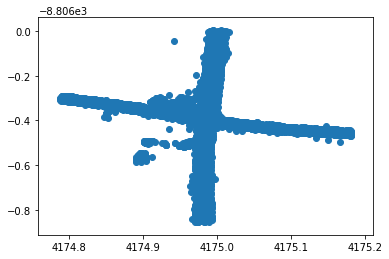

In [1050]:
### Distribution of the vehicle traces
plt.scatter(road_gps_data.Lattitude*100,road_gps_data.Longitude*100)

# DBSCAN Algorithm
The objective of the algorithm was to filter out the inaccuracies in the GPS data

In [1051]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np

Text(0,0.5,'Longitude')

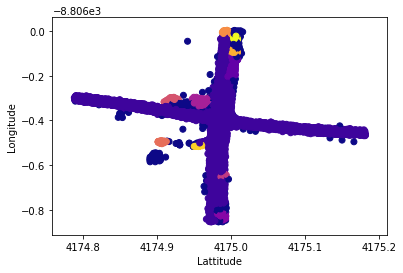

In [1052]:
dbscan_cluster_data = road_gps_data[['Lattitude','Longitude']]
# Scaling the trace data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(dbscan_cluster_data)

# DBSCAN Algorithm
dbscan = DBSCAN(eps=0.085, min_samples = 40)
clusters = dbscan.fit_predict(X_scaled)
# plot the cluster assignments
plt.scatter(dbscan_cluster_data.Lattitude*100, dbscan_cluster_data.Longitude*100, c=clusters, cmap="plasma")
plt.xlabel("Lattitude")
plt.ylabel("Longitude")


Text(0,0.5,'Longitude')

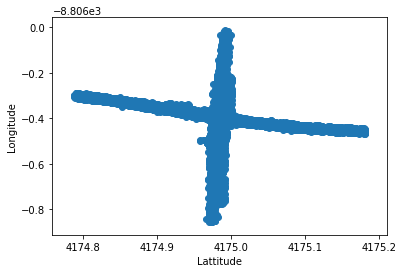

In [1053]:
dbscan_cluster_data['clusters'] = clusters
dbscan_cluster_data['DirOfTravel'] = road_gps_data['DirOfTravel']
dbscan_cluster_data['RoadId'] = road_gps_data['RoadId']
dbscan_cluster_data['Speed'] = road_gps_data['Speed']
dbscan_cluster_data['VehicleBearing'] = road_gps_data['VehicleBearing']
dbscan_cluster_data['VehicleID'] = road_gps_data['VehicleID']
dbscan_cluster_data['TimeStamp'] = road_gps_data['TimeStamp']

### Taking the dominant Cluster and treating all other clusters as noise###
dbscan_cluster_data_dominantcluster = dbscan_cluster_data[dbscan_cluster_data.clusters == 0]
plt.scatter(dbscan_cluster_data_dominantcluster.Lattitude*100, dbscan_cluster_data_dominantcluster.Longitude*100, cmap="plasma")
plt.xlabel("Lattitude")
plt.ylabel("Longitude")

# GEOJson Object
Obtaining the geometry of the roads for lane identification

In [1054]:
## Reading the GeoJSON Object ###

norm = np.linalg.norm

with open('C:\\Users\\559211\\Documents\\HERE\\roads - Copy.json') as f:
    gj = geojson.load(f)
features = gj['features']

In [1055]:
lane_df = pd.DataFrame([(x["id"],x["geometry"]["coordinates"],x["properties"]["direction"]) for x in features],columns=['id','coordinates','direction'])


In [1056]:
### Function to identify closest point on a line from an exterior point ###
def closest_point_on_line(p1, p2, p3):
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    dx, dy = x2-x1, y2-y1
    det = dx*dx + dy*dy
    a = (dy*(y3-y1)+dx*(x3-x1))/det
    return x1+a*dx, y1+a*dy

### Function to calculate the perpendicular distance of GPS trace from the identified closest point on the line ###
def get_perpendicular_distance_inmeters(vehicles_lane_df,roadId):
    vehicles_lane_df['closestpoint'] = None
    ### Getting the start and end cordinates for a lane and taking on lat/long and converting it to tuple ###
    origin = tuple(reversed(lane_df.loc[lane_df.id == roadId,'coordinates'].values[0][0][:2]))
    dest = tuple(reversed(lane_df.loc[lane_df.id == roadId,'coordinates'].values[0][-1][:2]))
    
    for index, row in vehicles_lane_df.iterrows():
        p3 = (row['Lattitude'],row['Longitude'])

        p4 = closest_point_on_line(origin,dest,p3)
        vehicles_lane_df.at[index,'closestpoint'] = str(p4)
        vehicles_lane_df.at[index,'distance'] = geodesic(p4, p3).meters

    return vehicles_lane_df

### Clustering the GPS traces to get the number of lanes in each direction ###
def get_numberof_lanes(vehicles_lane_df):
    ### Take only vehicles which have at least 2 trace ###
    vehicles_lane_df = vehicles_lane_df.groupby('VehicleID').filter(lambda x: len(x) >= 2)
    
    ## For each vehicle on this lane, get mean and standard deviation of perpendicular distances for that vehicle ### 
    unique_vehicle_ids = pd.DataFrame(vehicles_lane_df.groupby('VehicleID')['distance'].mean()).reset_index()
    if(unique_vehicle_ids.shape[0]>0):
        unique_vehicle_ids['stddev'] = vehicles_lane_df[['VehicleID','distance']].groupby(['VehicleID']).apply(np.std).reset_index()['distance']
        ## 'distance' column refers to the mean distance
        unique_vehicle_ids = unique_vehicle_ids[unique_vehicle_ids.stddev < 2.0]
        unique_vehicle_ids['lanes'] = None
        
        ## Cluster 1 identified as 'inlane' clusters
        unique_vehicle_ids.loc[unique_vehicle_ids.distance <= 1.85,'lanes'] = 'inlane'

        ## 8 clusters with a width of 3.7 meters ##
        for n in range(0,8):
            w = 1.7 + n*3.5
            unique_vehicle_ids.loc[(unique_vehicle_ids.distance > w) & (unique_vehicle_ids.distance <= w + 3.7),'lanes'] = 'lane'+str(n)
        
                    
        ## Keep lanes for which at least 2 cars have been identified ##
        unique_vehicle_ids = unique_vehicle_ids.groupby('lanes').filter(lambda x: len(x) >= 2)
        
    
        return len(list(filter(None, unique_vehicle_ids.lanes.unique()))),unique_vehicle_ids
    else:
        return 0,unique_vehicle_ids

In [1057]:
### Calling the functiond to get the number of lanes based on the vehicle trace  for each 'RoadId'##
for i,rows in lane_df.iterrows():
    vehicles_lane_df = dbscan_cluster_data[dbscan_cluster_data['RoadId'].astype(str) == str(rows['id'])]
    vehicles_lane_df = get_perpendicular_distance_inmeters(vehicles_lane_df,rows['id'])
    ## Get Forward lanes
    number_lanes,unique_vehicles_df = get_numberof_lanes(vehicles_lane_df[vehicles_lane_df.DirOfTravel == True])
    lane_df.loc[lane_df.id == rows['id'],'numberoflanes_Forward'] = number_lanes
    ## Get Backward Backward
    number_lanes,unique_vehicles_df = get_numberof_lanes(vehicles_lane_df[vehicles_lane_df.DirOfTravel == False])
    lane_df.loc[lane_df.id == rows['id'],'numberoflanes_Backward'] = number_lanes

# Evaluation
We show the evaluation for one road Id = 4355192737

In [1058]:

vehicles_lane_df = dbscan_cluster_data[dbscan_cluster_data['RoadId'].astype(str) == str('4355192737')]
vehicles_lane_df = get_perpendicular_distance_inmeters(vehicles_lane_df,'4355192737')


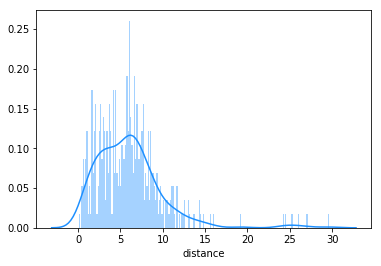

In [1059]:
import seaborn as sns
sns.distplot(vehicles_lane_df['distance'] , bins=200, color="dodgerblue", label="Compact")
#gaussian_cluster_df.distance.max()

In [1060]:
## Shapiro Test for each window ##
total_lanes = 0
alpha = 0.05

dist_data = vehicles_lane_df.loc[(vehicles_lane_df.distance <= 1.7), 'distance']
if (len(dist_data) >= 8):
    stat, p = normaltest(dist_data)
    if p > alpha:
        total_lanes = total_lanes + 1

for n in range(0,8):
    ## Shapiro Test for each window ##
    w = 1.7 + n*3.5
    dist_data = vehicles_lane_df.loc[(vehicles_lane_df.distance > w) & (vehicles_lane_df.distance <= w + 3.5), 'distance']
    if (len(dist_data) >= 8):
        stat, p = normaltest(dist_data)
        if p > alpha:
            total_lanes = total_lanes + 1


In [1061]:
print("Total Lanes for roadId = 4355192737 : " + str(total_lanes))

Total Lanes for roadId = 4355192737 : 2


# Result
The dataframe 'lane_df' provides number of lanes predicted in each direction as separate columns

In [1062]:
lane_df

,id,coordinates,direction,numberoflanes_Forward,numberoflanes_Backward
0,428043451,"[[-88.06395, 41.74979, 0], [-88.06334, 41.7498...",Backward,7.0,0.0
1,7419044380,"[[-88.06481, 41.7499, 0], [-88.064, 41.74991, 0]]",Forward,0.0,2.0
2,7419044379,"[[-88.06513, 41.74989, 0], [-88.06481, 41.7499...",Forward,0.0,2.0
3,5781502793,"[[-88.0635, 41.74898, 0], [-88.06358, 41.74912...",Both,3.0,0.0
4,5781502781,"[[-88.06454, 41.75175, 0], [-88.06457, 41.7522...",Both,0.0,1.0
5,4355192737,"[[-88.07427, 41.74935, 0], [-88.07369, 41.7494...",Backward,2.0,0.0
6,5781502792,"[[-88.06337, 41.74875, 0], [-88.0635, 41.74898...",Both,4.0,3.0
7,5781502784,"[[-88.06415, 41.75029, 0], [-88.06424, 41.7505...",Both,4.0,4.0
8,8461244179,"[[-88.06358, 41.74912, 0], [-88.06373, 41.7494...",Both,4.0,4.0
9,4483200876,"[[-88.06694, 41.74986, 0], [-88.06642, 41.7498...",Forward,0.0,2.0
